# Mathematical Engineering - Financial Engineering, FY 2024-2025
# Risk Management - Exercise 2: Corporate Bond Portfolio

In [13]:
# Importing the libraries
### !!! IMPORT USEFUL LIBRARIES HERE !!! ###
%load_ext autoreload
%autoreload 2

from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ex1_utilities import business_date_offset, year_frac_act_x, date_series
from ex2_utilities import (
    constant_intensity_from_bond,
    defaultable_bond_dirty_price_from_z_spread,
    piece_wise_constant_intensity_from_bonds,

)
from bootstrap import bootstrap
import datetime as dt
from utilities import read_mat_file_dates
from utilities import read_mat_file_rates
from utilities import convert_date_to_string


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# !!! READ MARKET AND BOOTSTRAP DATA !!!
datesSet = read_mat_file_dates("datesSet.mat")
datesSetNew = {"settlement":convert_date_to_string(datesSet["settlement"]), "depos": convert_date_to_string(datesSet["depos"]),
               "futures_settlement": convert_date_to_string(datesSet["futures_settlement"]), "futures_expiry": convert_date_to_string(datesSet["futures_scadenza"]),
               "swaps": convert_date_to_string(datesSet["swaps"])}
ratesSet = read_mat_file_rates("ratesSet.mat")
[dates, discounts] = bootstrap(datesSetNew,ratesSet)
discounts = [1] +  discounts
dates = datesSetNew["settlement"] + dates
dates = [dt.datetime.strptime(date, "%Y-%m-%d") for date in dates]
today = dates[0]
discount_factors = discounts

In [15]:
# Parameters
maturity1 = 1  # Maturity in years
maturity2 = 2
notional1 = 1e7
notional2 = 1e7
coupon_rate1 = 0.05
coupon_rate2 = 0.06
coupon_freq1 = 2  # Coupon frequency in payments a years
coupon_freq2 = 2
dirty_price1 = 1.00
dirty_price2 = 1.02

rating = "IG"  # Credit rating

expiry1 = business_date_offset(today, year_offset=maturity1)
expiry2 = business_date_offset(today, year_offset=maturity2)

In [16]:
# Q1: Derive the average intensity for the two bonds
recovery_rate = 0.3


h_1y = constant_intensity_from_bond(today,
    expiry1,
    coupon_rate1,
    coupon_freq1,
    dates,
    discount_factors,
    dirty_price1,
    recovery_rate,0)

h_2y = constant_intensity_from_bond(today,
    expiry2,
    coupon_rate2,
    coupon_freq2,
    dates,
    discount_factors,
    dirty_price2,
    recovery_rate,0)



print(f"Average intensity over {maturity1}y: {h_1y[0]:.6%}")
print(f"Average intensity over {maturity2}y: {h_2y[0]:.6%}")


Average intensity over 1y: 2.438963%
Average intensity over 2y: 2.433770%


In [17]:
# Q2: Default probability estimates
# Survival probabilities
# !!! COMPLETE AS APPROPRIATE !!!

surv_prob_1y = np.exp(-h_1y*year_frac_act_x([today],[expiry1],3))
surv_prob_2y = np.exp(-h_2y*year_frac_act_x([today],[expiry2],3))


default_prob_1y =  1- surv_prob_1y
default_prob_2y = 1- surv_prob_2y
np.array(default_prob_1y)
np.array(default_prob_2y)
print(f"{maturity1}y default probability: {default_prob_1y.item():.6%}")
print(f"{maturity2}y default probability: {default_prob_2y.item():.6%}")



1y default probability: 2.409461%
2y default probability: 4.763675%


In [18]:
# Q3: Z-spread calculation
z_spread_1y = fsolve(
    lambda z_spread: defaultable_bond_dirty_price_from_z_spread(
        today,
        expiry1,
        coupon_rate1,
        coupon_freq1,
        z_spread,
        dates,
        discount_factors,
        1.00,
    )
     - dirty_price1,
    x0=0.02,
)[0]

z_spread_2y = fsolve(
    lambda z_spread: defaultable_bond_dirty_price_from_z_spread(
        today,
        expiry2,
        coupon_rate2,
        coupon_freq2,
        z_spread,
        dates,
        discount_factors,
        1.00,
    )
    - dirty_price2,
    x0=0.02,
)[0]

print(f"Z-spread over {maturity1}y: {z_spread_1y:.6%}")
print(f"Z-spread over {maturity2}y: {z_spread_2y:.6%}")

Z-spread over 1y: 1.721444%
Z-spread over 2y: 1.727300%


In [19]:
# Q4: Default probability estimates under the hp. of piecewise constant intensity
# !!! COMPLETE AS APPROPRIATE !!!
v = piece_wise_constant_intensity_from_bonds(today,
    [expiry1,expiry2],
    [coupon_rate1,coupon_rate2],
    [coupon_freq1, coupon_freq2],
    dates,
    discount_factors,
    [dirty_price1, dirty_price2],
    recovery_rate,
)
print(f"Piecewise constant intensity over {maturity1}y: {v[0]:.6%}")
print(f"Piecewise constant intensity over {maturity2}y: {v[1]:.6%}")

Piecewise constant intensity over 1y: 2.438963%
Piecewise constant intensity over 2y: 2.429167%


In [20]:
# Survival probabilities
# !!! COMPLETE AS APPROPRIATE !!!

surv_prob_1y = np.exp(-v[0]*year_frac_act_x([today],[expiry1],3))
surv_prob_2y = np.exp(-v[0]*year_frac_act_x([today],[expiry1],3))*np.exp(-v[1]*year_frac_act_x([expiry1],[expiry2],3))

# Defaul probabilities
# !!! COMPLETE AS APPROPRIATE !!!
default_prob_1y = 1-surv_prob_1y
default_prob_2y = 1-surv_prob_2y

print(f"{maturity1}y default probability: {default_prob_1y[0]:.6%}")
print(f"{maturity2}y default probability: {default_prob_2y[0]:.6%}")

1y default probability: 2.409461%
2y default probability: 4.764214%


In [21]:
# Q5:Real world default probability from the rating transition matrix
# Simplified rating transition matrix at 1y
transition_matrix = pd.DataFrame(
    [[0.73, 0.25, 0.02], [0.35, 0.6, 0.05], [0, 0, 1]],
    index=["IG", "HY", "Def"],
    columns=["IG", "HY", "Def"],
)

# !!! COMPLETE AS APPROPRIATE !!!
transition_matrix_2y = np.linalg.matrix_power(transition_matrix, 2)
print(transition_matrix_2y)

transition_matrix_2y = pd.DataFrame(
    transition_matrix_2y,
    index=["IG", "HY", "Def"],
    columns=["IG", "HY", "Def"]
)

print(
    f"One year real world default probability: {transition_matrix.at[rating, 'Def']:.2%}"
)
print(
    f"Two year real world default probability: {transition_matrix_2y.at[rating, 'Def']:.2%}"
)

[[0.6204 0.3325 0.0471]
 [0.4655 0.4475 0.087 ]
 [0.     0.     1.    ]]
One year real world default probability: 2.00%
Two year real world default probability: 4.71%


In [22]:
# Q6: Estimate the default probabilities under a shock scenario of the mid-term survival probability (Scenario1)
dirty_price1_shock = dirty_price1
dirty_price2_shock = 0.97

# !!! COMPLETE AS APPROPRIATE !!!
intensities_shock  = piece_wise_constant_intensity_from_bonds(today,
    [expiry1,expiry2],
    [coupon_rate1,coupon_rate2],
    [coupon_freq1, coupon_freq2],
    dates,
    discount_factors,
    [dirty_price1_shock, dirty_price2_shock],
    recovery_rate,
)
print(f"Piecewise constant shock intensity over {maturity1}y: {intensities_shock[0]:.6%}")
print(f"Piecewise constant shock intensity over {maturity2}y: {intensities_shock[1]:.6%}")
# Survival probabilities
# !!! COMPLETE AS APPROPRIATE !!!
surv_prob_1y_shock = np.exp(-intensities_shock[0]*year_frac_act_x([today],[expiry1],3))
surv_prob_2y_shock = np.exp(-intensities_shock[0]*year_frac_act_x([today],[expiry1],3))*np.exp(-intensities_shock[1]*year_frac_act_x([expiry1],[expiry2],3))
# Defaul probabilities
# !!! COMPLETE AS APPROPRIATE !!!
default_prob_1y_shock = 1-surv_prob_1y_shock
default_prob_2y_shock = 1-surv_prob_2y_shock

print(f"{maturity1}y default shock probability: {default_prob_1y_shock[0]:.6%}")
print(f"{maturity2}y default shock probability: {default_prob_2y_shock[0]:.6%}")

Piecewise constant shock intensity over 1y: 2.438963%
Piecewise constant shock intensity over 2y: 6.221046%
1y default shock probability: 2.409461%
2y default shock probability: 8.326880%


In [23]:
# Q7: Estimate the default probabilities under a shock scenario on overall creditworthiness (Scenario2)
dirty_price1_shock2 = 1.010
dirty_price2_shock2 = 1.030

# !!! COMPLETE AS APPROPRIATE !!!
intensities_shock2  = piece_wise_constant_intensity_from_bonds(today,
    [expiry1,expiry2],
    [coupon_rate1,coupon_rate2],
    [coupon_freq1, coupon_freq2],
    dates,
    discount_factors,
    [dirty_price1_shock2, dirty_price2_shock2],
    recovery_rate,
)

# Survival probabilities
# !!! COMPLETE AS APPROPRIATE !!!
surv_prob_1y_shock2 = np.exp(-intensities_shock2[0]*year_frac_act_x([today],[expiry1],3))
surv_prob_2y_shock2 = np.exp(-intensities_shock2[1]*year_frac_act_x([expiry1],[expiry2],3))*np.exp(-intensities_shock2[0]*year_frac_act_x([today],[expiry1],3))

# Defaul probabilities
# !!! COMPLETE AS APPROPRIATE !!!
default_prob_1y_shock2 = 1-surv_prob_1y_shock2
default_prob_2y_shock2 = 1-surv_prob_2y_shock2

print(f"{maturity1}y default shock2 probability: {default_prob_1y_shock2[0]:.6%}")
print(f"{maturity2}y default shock2 probability: {default_prob_2y_shock2[0]:.6%}")

1y default shock2 probability: 1.004471%
2y default shock2 probability: 2.700512%


Conditional default probability (historical): 2.765306%
Conditional default probability (Scenario 1): 6.063517%


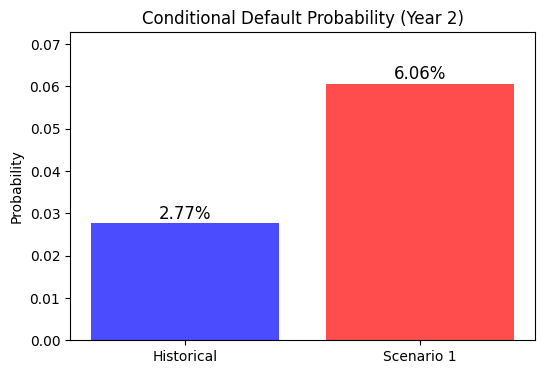

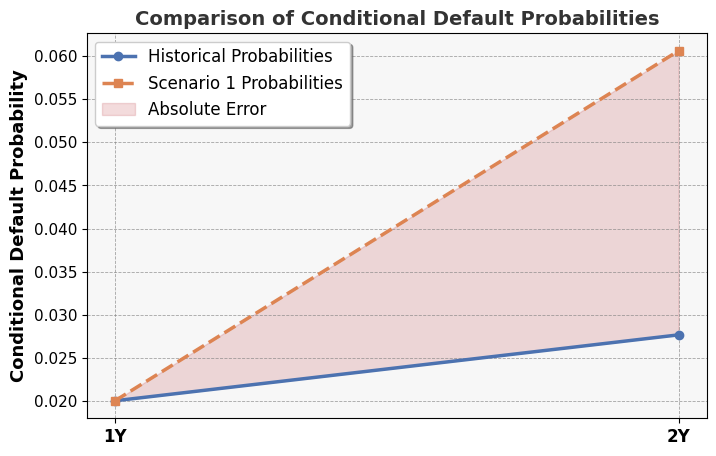

In [24]:
# Q8: Are the conditional default probabilities between the first and the second year derived under the scenario 1
# consistent with the equivalent real-world probabilities derived from the transition matrix?
# !!! COMPLETE AS APPROPRIATE !!!
p_def_1y = transition_matrix.at[rating, 'Def']
p_def_2y = transition_matrix_2y.at[rating, 'Def']
p_def_cond_2y = (p_def_2y - p_def_1y) / (1 - p_def_1y)
print(f"Conditional default probability (historical): {p_def_cond_2y:.6%}")


p_def_cond_2y_scenario = (default_prob_2y_shock[0] - default_prob_1y_shock[0])/surv_prob_1y_shock[0]


print(f"Conditional default probability (Scenario 1): {p_def_cond_2y_scenario:.6%}")



labels = ["Historical", "Scenario 1"]
values = [p_def_cond_2y, p_def_cond_2y_scenario]


plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['blue', 'red'], alpha=0.7)


for i, v in enumerate(values):
    plt.text(i, v + 0.001, f"{v:.2%}", ha='center', fontsize=12)


plt.title("Conditional Default Probability (Year 2)")
plt.ylabel("Probability")
plt.ylim(0, max(values) * 1.2)

plt.show()


years = [1, 2]
historical_probs = [p_def_1y, p_def_cond_2y]
scenario_probs = [p_def_1y, p_def_cond_2y_scenario]


error = np.abs(np.array(scenario_probs) - np.array(historical_probs))


plt.figure(figsize=(8, 5), dpi=100)


historical_color = "#4c72b0"
scenario_color = "#dd8452"
error_color = "#c44e52"


plt.plot(years, historical_probs, marker='o', linestyle='-', linewidth=2.5, color=historical_color, label="Historical Probabilities")
plt.plot(years, scenario_probs, marker='s', linestyle='--', linewidth=2.5, color=scenario_color, label="Scenario 1 Probabilities")


plt.fill_between(years, historical_probs, scenario_probs, color=error_color, alpha=0.2, label="Absolute Error")


plt.xticks(years, labels=["1Y", "2Y"], fontsize=12, fontweight="bold")
plt.yticks(fontsize=11)
plt.ylabel("Conditional Default Probability", fontsize=13, fontweight="bold")
plt.title("Comparison of Conditional Default Probabilities", fontsize=14, fontweight="bold", color="#333")


plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=12, loc="upper left")


plt.grid(True, linestyle="--", linewidth=0.6, alpha=0.7, color="gray")


plt.gca().set_facecolor("#f7f7f7")


plt.show()
